# Understanding Tensorflow MDN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.utils import shuffle
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input

True function, $f(x)$

In [2]:
def f(x):
    return np.sin(0.25*x)

True function plus noise that varies with $x$, $g(x)$

In [3]:
sigma_0 = 0.01
samples = 100
def g(x):
    return np.random.normal(f(x), sigma_0*x, samples)

Visualizing $g(x)$

In [4]:
x_vals = np.arange(0,12*np.pi + np.pi/4, np.pi/4)
x_arr = np.array([])
y_arr = np.array([])
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, g(x))
x_arr, y_arr = shuffle(x_arr, y_arr)

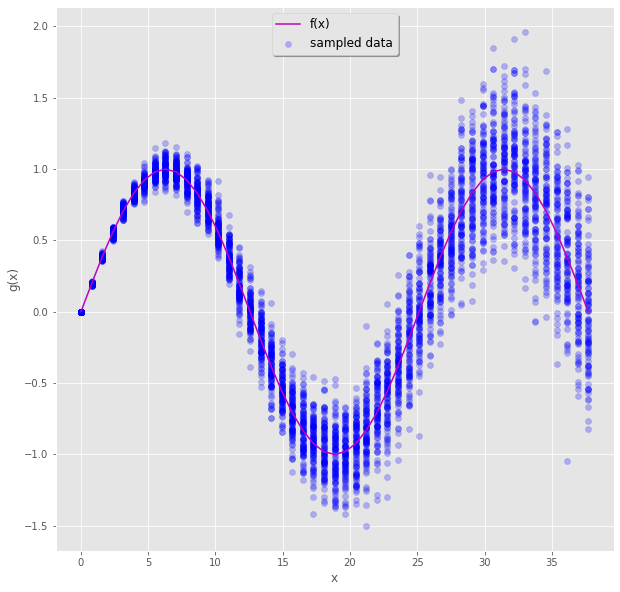

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr, c='b', alpha=0.25, label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

# Non-MDN: Simple dense network outputting predicted mean value

Training simple 2-layer dense network to estimate $\hat f(x)$

First hyperparameter search for batch size and learning rate

In [6]:
epochs = 500
batch_size_s = [25, 50, 100, 250]
learning_rate_s = [0.0001, 0.0002, 0.0004, 0.001, 0.002, 0.004]

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))

mse = np.ndarray((len(batch_size_s), len(learning_rate_s)))
for i,batch_size in enumerate(batch_size_s):
    for j,learning_rate in enumerate(learning_rate_s):
        model.compile(loss='mse',optimizer=optimizers.Adam(learning_rate=learning_rate))
        history_cache = model.fit(x_arr,
                                y_arr,
                                verbose=0, # write = 1 if you wish to see the progress for each epoch
                                epochs=epochs,
                                batch_size=batch_size)

        print('batch size = {}, learning_rate = {}'.format(batch_size, learning_rate))
        mse[i][j] = model.evaluate(x_arr, y_arr, batch_size=batch_size)
        print()

batch size = 25, learning_rate = 0.0001
196/196 [==============================] - 0s 1ms/step - loss: 0.0545

batch size = 25, learning_rate = 0.0002
196/196 [==============================] - 0s 1ms/step - loss: 0.0472

batch size = 25, learning_rate = 0.0004
196/196 [==============================] - 0s 1ms/step - loss: 0.0482

batch size = 25, learning_rate = 0.001
196/196 [==============================] - 0s 1ms/step - loss: 0.0487

batch size = 25, learning_rate = 0.002
196/196 [==============================] - 0s 909us/step - loss: 0.0486

batch size = 25, learning_rate = 0.004
196/196 [==============================] - 0s 895us/step - loss: 0.0543

batch size = 50, learning_rate = 0.0001
98/98 [==============================] - 0s 904us/step - loss: 0.0468

batch size = 50, learning_rate = 0.0002
98/98 [==============================] - 0s 1ms/step - loss: 0.0466

batch size = 50, learning_rate = 0.0004
98/98 [==============================] - 0s 919us/step - loss: 0.0469

ba

Text(0.5, 0, 'learning rate idx')

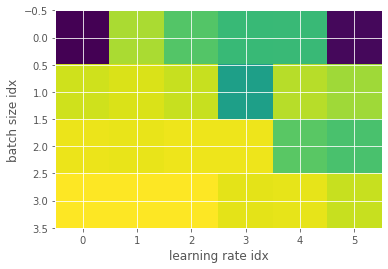

In [7]:
plt.imshow(1/mse)
plt.ylabel('batch size idx')
plt.xlabel('learning rate idx')

First pass at training with best discovered batch size and learning rate

In [8]:
epochs = 500
best_batch_size_idx, best_learning_rate_idx = np.where(mse == np.min(mse))
batch_size = batch_size_s[int(best_batch_size_idx)]
learning_rate = learning_rate_s[int(best_learning_rate_idx)]
model.compile(loss='mse',optimizer=optimizers.Adam(learning_rate=learning_rate))

In [9]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write = 1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='loss', verbose=0, save_best_only=True)])

final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

20/20 [==============================] - 0s 1ms/step - loss: 0.0462


Fine-tuning model

In [10]:
model.compile(loss='mse',optimizer=optimizers.Adam(learning_rate=learning_rate*0.1))
model.load_weights('best_model.h5')

In [11]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write = 1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='loss', verbose=0, save_best_only=True)])

final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

20/20 [==============================] - 0s 1ms/step - loss: 0.0462


#### Visualize performance

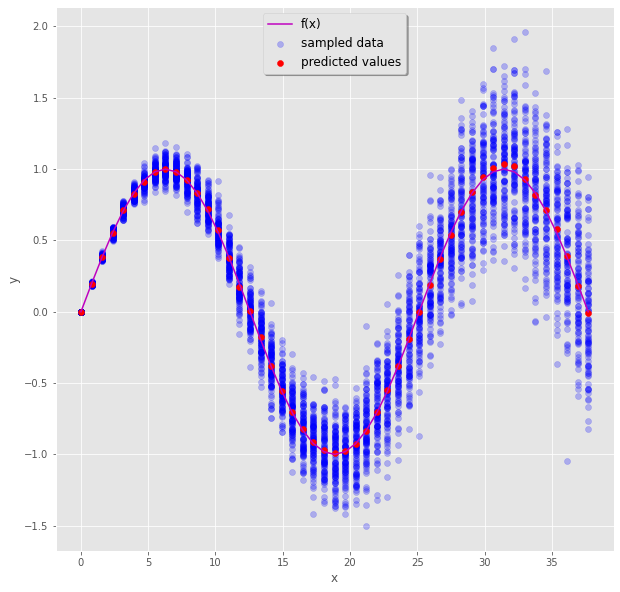

Final cost: 0.0462


In [12]:
y_pred = model.predict(x_vals)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b', alpha=0.25, label='sampled data')
ax.scatter(x_vals,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(final_mse))

# MDN: Simple dense network outputting mixture parameters

Using same architecture but with MDN final layer instead of 1 neuron dense layer. Finds conditional distribution for each point as opposed to only the mean of the conditional distribution at each point (the predicted mean value).

Hyper-param search

In [13]:
epochs = 500
batch_size_s = [25, 50, 100, 250]
learning_rate_s = [0.0001, 0.0002, 0.0004, 0.001, 0.002, 0.004]
mse = np.ndarray((len(batch_size_s), len(learning_rate_s)))


event_shape = [1]
num_components = 1
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)

model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(params_size, activation=None))
model.add(tfp.layers.MixtureNormal(num_components, event_shape,
                                    convert_to_tensor_fn=lambda X: tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)))

for i,batch_size in enumerate(batch_size_s):
    for j,learning_rate in enumerate(learning_rate_s):
        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                    loss=lambda y, model: -model.log_prob(y))
        
        history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)

        print('batch size = {}, learning_rate = {}'.format(batch_size, learning_rate))
        mse[i][j] = model.evaluate(x_arr, y_arr, batch_size=batch_size)
        print()

batch size = 25, learning_rate = 0.0001
196/196 [==============================] - 1s 1ms/step - loss: -0.4504

batch size = 25, learning_rate = 0.0002
196/196 [==============================] - 1s 1ms/step - loss: -0.5373

batch size = 25, learning_rate = 0.0004
196/196 [==============================] - 1s 1ms/step - loss: -0.5567

batch size = 25, learning_rate = 0.001
196/196 [==============================] - 0s 1ms/step - loss: -0.5798

batch size = 25, learning_rate = 0.002
196/196 [==============================] - 1s 1ms/step - loss: -0.5417

batch size = 25, learning_rate = 0.004
196/196 [==============================] - 1s 1ms/step - loss: -0.5481

batch size = 50, learning_rate = 0.0001
98/98 [==============================] - 0s 1ms/step - loss: -0.6202

batch size = 50, learning_rate = 0.0002
98/98 [==============================] - 0s 1ms/step - loss: -0.6310

batch size = 50, learning_rate = 0.0004
98/98 [==============================] - 0s 998us/step - loss: -0.6202


Text(0.5, 0, 'learning rate idx')

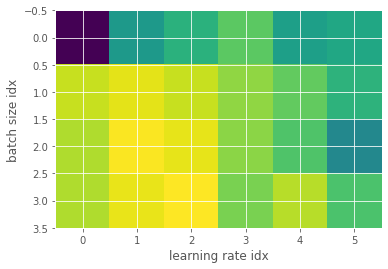

In [14]:
plt.imshow(1/mse)
plt.ylabel('batch size idx')
plt.xlabel('learning rate idx')

First pass at training with best batch size and learning rate

In [15]:
epochs = 500
best_batch_size_idx, best_learning_rate_idx = np.where(mse == np.min(mse))
batch_size = batch_size_s[int(best_batch_size_idx)]
learning_rate = learning_rate_s[int(best_learning_rate_idx)]
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
              loss=lambda y, model: -model.log_prob(y))

In [16]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint('./best_model_mdn.h5', monitor='loss', verbose=0, save_best_only=True)])

final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

20/20 [==============================] - 0s 1ms/step - loss: -0.6266


Fine-tuning model

In [17]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate*0.1),
              loss=lambda y, model: -model.log_prob(y))
model.load_weights('best_model_mdn.h5')

In [18]:
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[tf.keras.callbacks.ModelCheckpoint('./best_model_mdn.h5', monitor='loss', verbose=0, save_best_only=True)])

final_mse = model.evaluate(x_arr, y_arr, batch_size=batch_size)

20/20 [==============================] - 0s 1ms/step - loss: -0.6522


#### Visualize performance

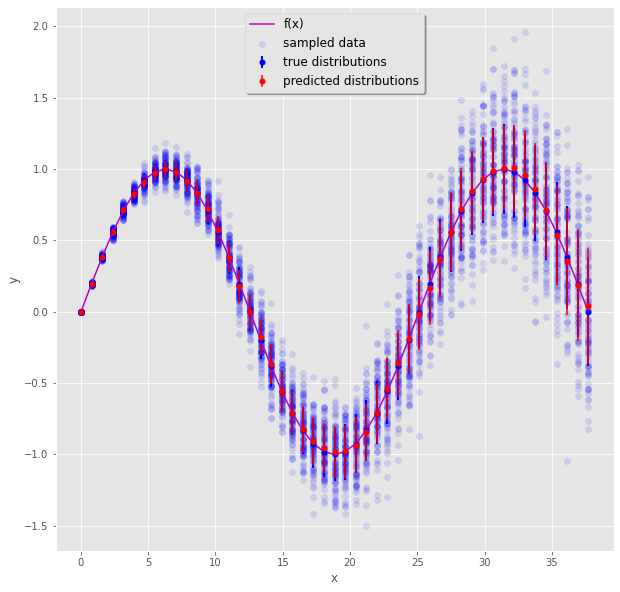

In [23]:
pred = model.predict(x_vals)
mu_pred = pred[:,0]
sigma_pred = pred[:,1]

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',alpha=0.1,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.errorbar(x_vals,mu_pred,yerr=sigma_pred,c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

Note that the above plots the mean and standard deviation of the mixture distribution. The mixture distribution is the linear combination of the component distributions with the mixing coefficients as weights for the linear combination. 

We need to remove the last layer with Tensorflow MDN implementation to get component means and standard deviations if the number of components was ever greater than 1.

In [24]:
model_output = Sequential(model.layers[:-1])

In [25]:
model_output.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


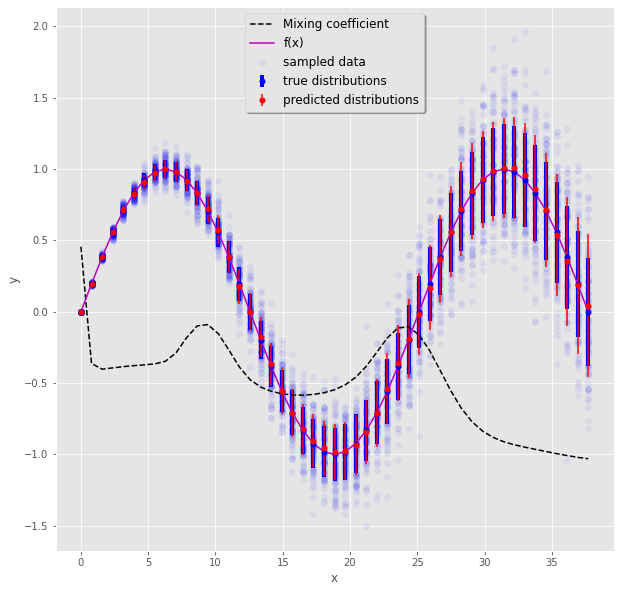

In [30]:
pred = model_output.predict(x_vals)
alpha_pred = pred[:,0]
mu_pred = pred[:,1]
sigma_pred = np.exp(pred[:,2])

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x_vals, alpha_pred, '--k', label='Mixing coefficient')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=4,ls='None',marker='.',ms=10,label='true distributions')
ax.errorbar(x_vals,mu_pred,yerr=sigma_pred,c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

There appears to be some difference in the predicted error near the end between the tensorflow mdn layer with one component and the decomposition above... haven't figured it out yet